In [1]:
# Imports

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
plt.style.use("ggplot")
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D
from keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D

In [2]:
def read_data():
    os.chdir('D:/TU_Graz/Thesis/Datasets/Reddit_features')

    train = pd.read_csv("train_final_all.csv")
    test = pd.read_csv("test_final_all.csv")
    data = train.append(test)
    #data = data[["Sentence", "Token", "POS_tag", "BIO"]]
    return train, test, data

In [3]:
def create_lists(data, category):
    words = list(set(data["Token"].values))
    words.append("ENDPAD")
    n_words = len(words)

    tags = list(set(data[category].values))
    n_tags = len(tags)
    
    chars = set([w_i for w in words for w_i in w])
    n_chars = len(chars)
    
    return words, n_words, tags, n_tags, chars, n_chars

In [4]:
def group_sentences(data, category):
    all_sents = []
    sent_ids = data['Sent_id'].unique()
    for curr_id in sent_ids:
        tmp_df = data[data['Sent_id'] == curr_id]
        tmp_df = pd.concat([tmp_df['Token'], tmp_df["Token_index"], tmp_df.iloc[:,4:149], tmp_df[category]], axis = 1)
        records = tmp_df.to_records(index=False)
        all_sents.append(records)
    return all_sents

In [5]:
def remove_sents_over_threshold(sents, threshold):
    sentences = list()
    for s in sents:
        if len(s) < threshold:
            sentences.append(s)
    return sentences

In [6]:
def prepare_and_pad(sentences, max_len, word2idx, tag2idx, char2idx, n_words, n_chars):
    X_word = [[word2idx[w[0]] for w in s] for s in sentences]
    X_word = pad_sequences(maxlen=max_len, sequences=X_word, value=n_words-1, padding='post', truncating='post')
    X_char = []
    for sentence in sentences:
        sent_seq = []
        for i in range(max_len):
            word_seq = []
            for j in range(max_len_char):
                try:
                    word_seq.append(char2idx.get(sentence[i][0][j]))
                except:
                    word_seq.append(n_chars)
            sent_seq.append(word_seq)
        X_char.append(np.array(sent_seq))
    
    X_feats = []
    for sentence in sentences:
        sent_ft = list()
        for word in sentence:
            ft = list()
            for i in range(1, 147):
                ft.append(word[i])
            sent_ft.append(ft)
        for j in range(len(sentence)-1, max_len-1):
            ft = list()
            for i in range(1, 147):
                ft.append(n_words-1)
            sent_ft.append(ft)
        X_feats.append(sent_ft)  
    
    y = [[tag2idx[w[len(w)-1]] for w in s] for s in sentences]
    y = pad_sequences(maxlen=max_len, sequences=y, value=tag2idx["O"], padding='post', truncating='post')

    
    return X_word, X_char, X_feats, y

In [7]:
def build_model(max_len, max_len_char, n_words, n_chars, n_tags):
    # input and embedding for words
    word_in = Input(shape=(max_len,))
    emb_word = Embedding(input_dim=n_words, output_dim=50, input_length=max_len, mask_zero=True)(word_in)

    # input and embeddings for characters
    char_in = Input(shape=(max_len, max_len_char,))
    emb_char = TimeDistributed(Embedding(input_dim=n_chars + 1, output_dim=50, input_length=max_len_char, mask_zero=True))(char_in)
    # character LSTM to get word encodings by characters
    char_enc = TimeDistributed(LSTM(units=20, return_sequences=False, recurrent_dropout=0.5))(emb_char)

    # Adding hand-picked features
    input_2 = Input(shape=(max_len, 146))
    fts = TimeDistributed(Dense(n_tags, activation = 'sigmoid'))(input_2)

    # main LSTM
    x = concatenate([emb_word, char_enc, fts])
    x = SpatialDropout1D(0.5)(x)
    main_lstm = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.7))(x)
    out = TimeDistributed(Dense(n_tags + 1, activation="sigmoid"))(main_lstm)

    model = Model([word_in, char_in, input_2], out)
    
    return model

In [8]:
def plot_learning_curves(hist, curve1, curve2):
    plt.figure(figsize=(6,6))
    plt.plot(hist[curve1])
    plt.plot(hist[curve2])
    plt.show()

Loading the data...
Done.
Creating sets of words and tags...
Done.
Creating sentence list...
Done.
Removing submissions longer than threshold...
Done.
Creating word, char and tag maps...
Done.
Preparing and padding training data...
Done.
Splitting data...
Building the model...
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 300, 10)]    0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
time_distributed_8 (TimeDistrib (None, 300, 10, 50)  5050        input_8[0][0]                    
____________

28/28 [==============================] - 47s 2s/step - loss: 0.0382 - acc: 0.9892 - val_loss: 0.0922 - val_acc: 0.9770
Epoch 40/50
28/28 [==============================] - 52s 2s/step - loss: 0.0370 - acc: 0.9893 - val_loss: 0.0926 - val_acc: 0.9769
Epoch 41/50
28/28 [==============================] - 46s 2s/step - loss: 0.0362 - acc: 0.9896 - val_loss: 0.0930 - val_acc: 0.9771
Epoch 42/50
28/28 [==============================] - 47s 2s/step - loss: 0.0356 - acc: 0.9897 - val_loss: 0.0936 - val_acc: 0.9770
Epoch 43/50
28/28 [==============================] - 47s 2s/step - loss: 0.0349 - acc: 0.9900 - val_loss: 0.0950 - val_acc: 0.9772
Epoch 44/50
28/28 [==============================] - 46s 2s/step - loss: 0.0339 - acc: 0.9900 - val_loss: 0.0927 - val_acc: 0.9770
Epoch 45/50
28/28 [==============================] - 47s 2s/step - loss: 0.0332 - acc: 0.9903 - val_loss: 0.0941 - val_acc: 0.9770
Epoch 46/50
28/28 [==============================] - 47s 2s/step - loss: 0.0328 - acc: 0.9904 -

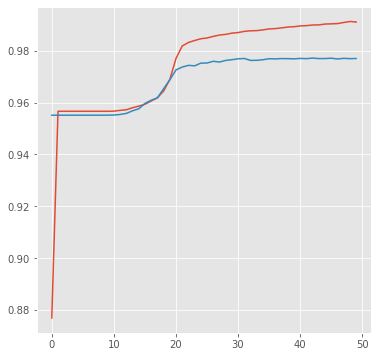

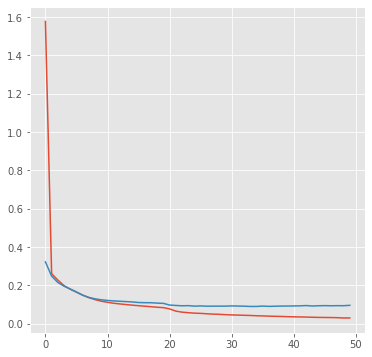

In [11]:
# Read the data
print("Loading the data...")
train, test, data = read_data()
print("Done.")

# Create word, tag and char lists
print("Creating sets of words and tags...")
words, n_words, tags, n_tags, chars, n_chars = create_lists(data, "BIO")
print("Done.")

# Create list of sentences
print("Creating sentence list...")
sents = group_sentences(data, 'BIO')
print("Done.")

# Remove submissions longer than a certain threshold
print("Removing submissions longer than threshold...")
sentences = remove_sents_over_threshold(sents, 300)
print("Done.")

# Create word, tag and char maps
print("Creating word, char and tag maps...")
max_len = 300
max_len_char = 10
word2idx = {w: i for i, w in enumerate(words)}
idx2word = {i: w for w, i in word2idx.items()}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {i: w for w, i in tag2idx.items()}
char2idx = {c: i for i, c in enumerate(chars)}
print("Done.")

# Pad data
print("Preparing and padding training data...")
X_word, X_char, X_feats, y = prepare_and_pad(sentences, max_len, word2idx, tag2idx, char2idx, n_words, n_chars)
print("Done.")

# Split to train and test
print("Splitting data...")
X_word_train, X_word_test, y1_train, y1_test = train_test_split(X_word, y, test_size=0.25, shuffle=False)
X_char_train, X_char_test, y2_train, y2_test = train_test_split(X_char, y, test_size=0.25, shuffle=False)
X_feats_train, X_feats_test, y2_train, y2_test = train_test_split(X_feats, y, test_size=0.25, shuffle=False)
y_test = y1_test
y_train = y1_train

# Build the model
print("Building the model...")
model = build_model(max_len, max_len_char, n_words, n_chars, n_tags)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])
model.summary()

# Fit the model
print("Fitting the model...")
history = model.fit([X_word_train,
                     np.array(X_char_train).reshape((len(X_char_train), max_len, max_len_char)),
                     np.array(X_feats_train).reshape((len(X_feats_train), max_len, 146))], 
                     np.array(y_train).reshape(len(y_train), max_len, 1), 
                     batch_size=32, epochs=50, validation_split=0.2, verbose=1)
hist = pd.DataFrame(history.history)

# Plotting learning curves
print("Plotting learning curves...")
plot_learning_curves(hist, "acc", "val_acc")
plot_learning_curves(hist, "loss", "val_loss")

In [ ]:
y_pred = model.predict([X_word_test, np.array(X_char_test).reshape((len(X_char_test), max_len, max_len_char)), 
                       np.array(X_feats_test).reshape((len(X_feats_test), max_len, 146))])
p = np.argmax(y_pred, axis=-1)
y_orig = []
for sent in y_te:
    for tag in sent:
        y_orig.append(tag)
        
y_preds = []
for sent in p:
    for tag in sent:
        y_preds.append(tag)
        
report = classification_report( y_orig, y_preds )
print(report) 

In [ ]:
tag2idx

In [ ]:
i = 6
p = np.argmax(y_pred[i], axis=-1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_word_te[i], y_te[i], p):
    if w != n_words-1:
        print("{:15}: {:5} {}".format(idx2word[w], idx2tag[t], idx2tag[pred]))